# Data Exploration for QuickBooks Sales Forecasting

This notebook explores the sales data to identify patterns, trends, and insights that will inform our forecasting model.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
%matplotlib inline

### Data Loading and Preparation
In this section, we load the sales data from a CSV file, convert the date column to datetime format for time-based analysis, and display the first few rows to understand the structure of our dataset.


In [2]:
# Load the sales data
sales_df = pd.read_csv('../data/raw/sales.csv')

# Convert date to datetime
sales_df['date'] = pd.to_datetime(sales_df['date'])

# Display the first few rows
sales_df.head()

,date,category,product,units_sold,revenue,product_price,promo_flag,is_holiday_season,category_popularity_30d
0,2020-05-08,Electronics,Smart Speaker,7,991.63,141.66,0,0,1.03
1,2020-05-08,Groceries,Organic Cereal,307,1556.42,5.07,0,0,1.10
2,2020-05-08,Clothing,Running Shoes,54,3145.90,58.26,0,0,0.95
3,2020-05-08,Books,Business Book,86,1869.15,21.73,0,0,1.10
4,2020-05-08,Furniture,Office Chair,7,822.02,117.43,0,0,0.93


## Basic Statistics & Distribution

In [3]:
# Basic data information
print(f"Dataset shape: {sales_df.shape}")
print("\nData types:")
print(sales_df.dtypes)

print("\nSummary statistics:")
sales_df.describe()

Dataset shape: (14608, 9)

Data types:
date                       datetime64[ns]
category                           object
product                            object
units_sold                          int64
revenue                           float64
product_price                     float64
promo_flag                          int64
is_holiday_season                   int64
category_popularity_30d           float64
dtype: object

Summary statistics:


,date,units_sold,revenue,product_price,promo_flag,is_holiday_season,category_popularity_30d
count,14608,14608.000000,14608.000000,14608.000000,14608.000000,14608.000000,14608.000000
mean,2022-11-06 12:00:00,116.593647,2683.376350,57.503693,0.161008,0.167032,1.000592
min,2020-05-08 00:00:00,0.000000,0.000000,4.170000,0.000000,0.000000,0.700000
25%,2021-08-07 00:00:00,29.000000,1848.452500,22.335000,0.000000,0.000000,0.930000
50%,2022-11-06 12:00:00,73.000000,2379.750000,39.295000,0.000000,0.000000,1.000000
75%,2024-02-06 00:00:00,147.000000,3338.442500,77.182500,0.000000,0.000000,1.070000
max,2025-05-07 00:00:00,735.000000,9054.940000,175.510000,1.000000,1.000000,1.300000
std,NaN,125.734160,1245.299361,48.052304,0.367551,0.373017,0.099492


In [4]:
# Null value check
sales_df.isnull().sum()

date                       0
category                   0
product                    0
units_sold                 0
revenue                    0
product_price              0
promo_flag                 0
is_holiday_season          0
category_popularity_30d    0
dtype: int64

In [5]:
# Check for duplicates
sales_df.duplicated().sum()

np.int64(0)

### Distribution Analysis of Numerical Features
Let's examine the distribution of key numerical features in our dataset to understand their central tendencies, spread, and identify any outliers or skewness.


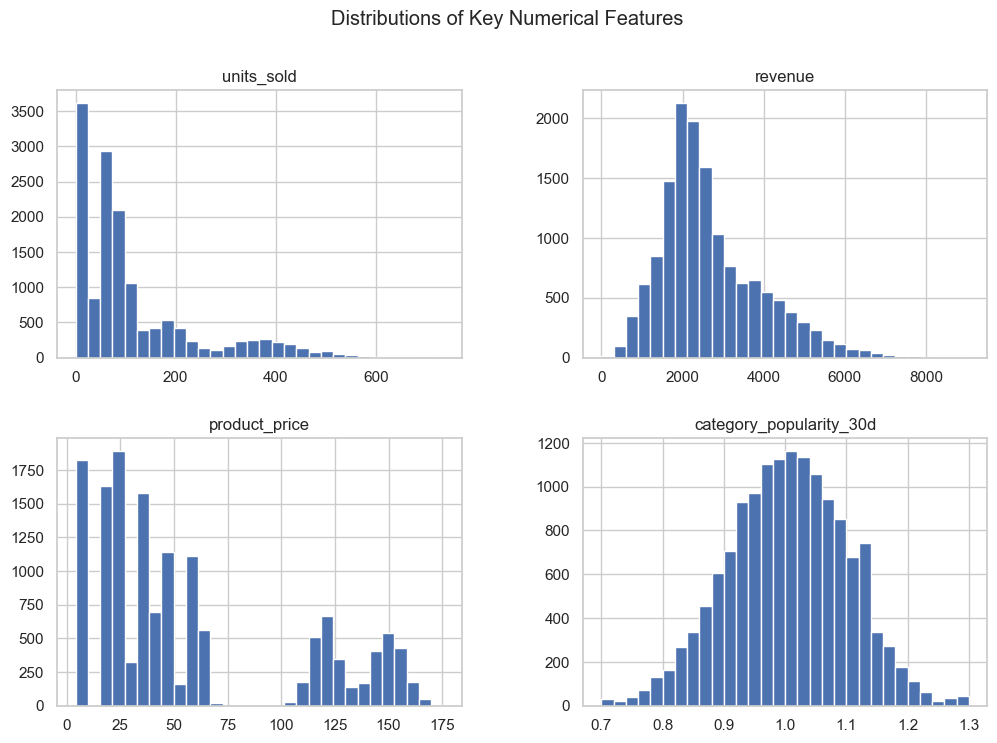

In [6]:
numerical_cols = ['units_sold', 'revenue', 'product_price', 'category_popularity_30d']

# Histograms for distributions
sales_df[numerical_cols].hist(bins=30, figsize=(12, 8))
plt.suptitle("Distributions of Key Numerical Features")
plt.show()

#### Insights from Distributions
The histograms reveal several important characteristics of our data:
- **Revenue** shows a right-skewed distribution, with many small transactions and fewer large ones, which is typical for sales data.
- **Units Sold** follows a similar pattern, with most transactions involving a small number of units.
- **Product Price** shows multiple peaks, suggesting distinct price points or product categories.
- **Category Popularity** appears more normally distributed, indicating that categories have varying levels of popularity that follow a somewhat natural distribution.

## Time Series Analysis
### Daily Sales Patterns
Now we'll analyze how sales vary over time by aggregating the data by date. This will help us identify any trends, seasonality, or anomalies in the sales data.


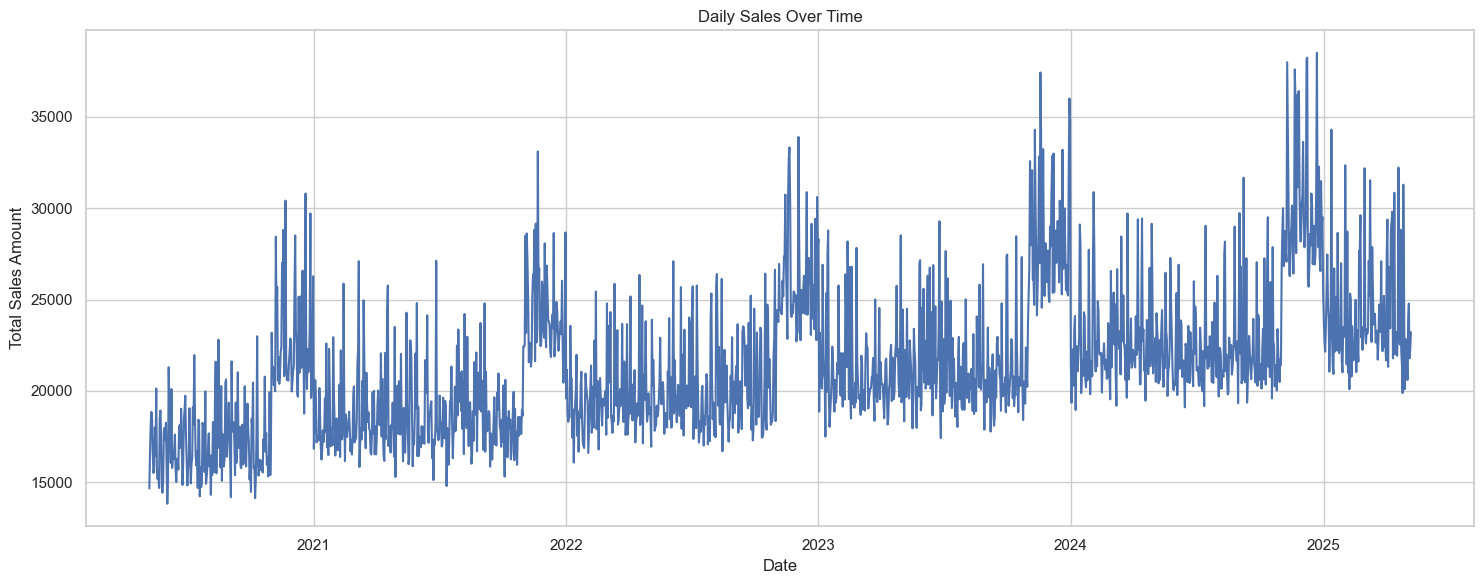

In [7]:
# Group by date and calculate daily sales
daily_sales = sales_df.groupby('date')['revenue'].sum().reset_index()

# Plot daily sales
plt.figure(figsize=(15, 6))
plt.plot(daily_sales['date'], daily_sales['revenue'])
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Insights from Daily Sales Trend
Daily sales exhibit high short-term volatility, with sharp peaks likely tied to promotions, holidays, or weekends. While no long-term growth trend is obvious, we observe stable recurring patterns across years, particularly strong Q4 surges — a sign of consistent seasonality. A few extreme outliers merit further analysis to distinguish between event-driven surges and possible anomalies.

### Rolling Averages for 7 & 30 days
To smooth out the daily fluctuations and better visualize the underlying trends, we'll calculate rolling averages over 7-day and 30-day windows. This helps us see short-term and medium-term trends more clearly.


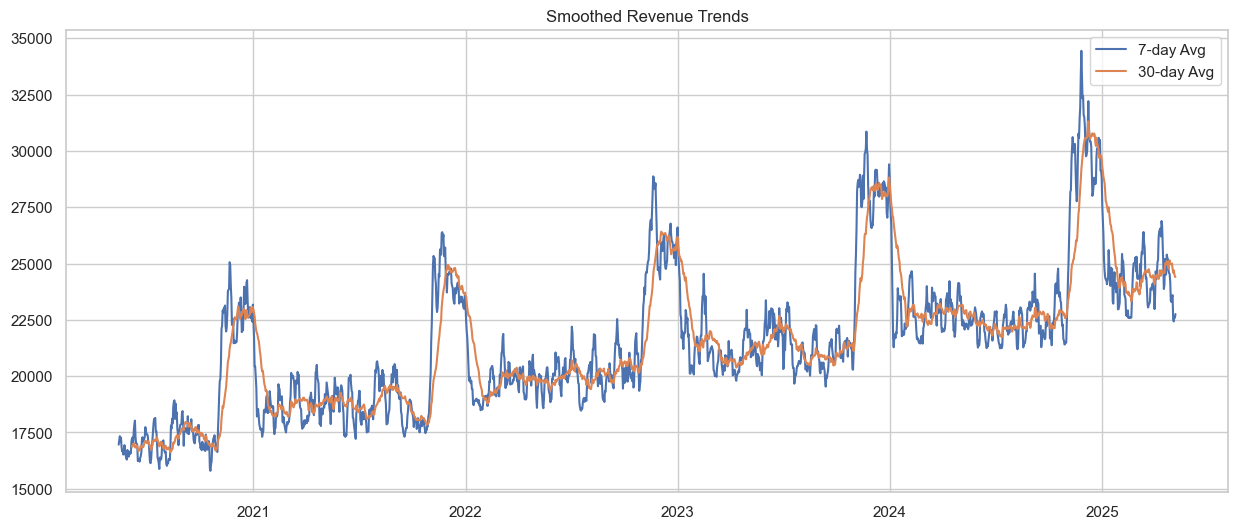

In [8]:
# Rolling averages
daily_sales['revenue_7d'] = daily_sales['revenue'].rolling(7).mean()
daily_sales['revenue_30d'] = daily_sales['revenue'].rolling(30).mean()

plt.figure(figsize=(15, 6))
plt.plot(daily_sales['date'], daily_sales['revenue_7d'], label='7-day Avg')
plt.plot(daily_sales['date'], daily_sales['revenue_30d'], label='30-day Avg')
plt.title('Smoothed Revenue Trends')
plt.legend()
plt.grid(True)
plt.show()

#### Insights from Rolling Averages
The combination of 7-day and 30-day moving averages gives us multi-resolution visibility into sales performance. Seasonal peaks are very consistent year over year, reinforcing the importance of accurate forecasting in Q4 windows. Volatility is visible through diverging moving averages, which could help inform inventory risk models or promo scheduling.

## Category-Level Patterns
### Total Sales by Category
Now we'll analyze sales performance at the category level to identify which product categories contribute most to overall revenue. This helps us understand the business's product mix and where to focus our forecasting efforts.


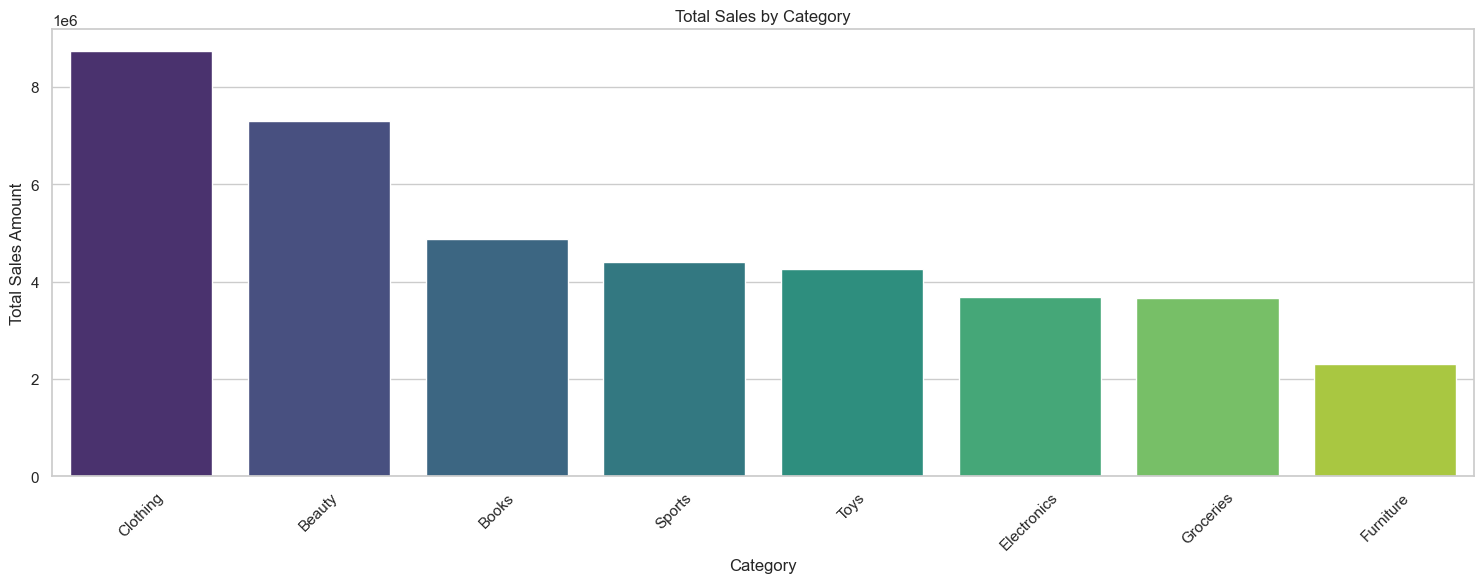

In [9]:
# Group by category and calculate total sales per category
category_sales = sales_df.groupby('category')['revenue'].sum().sort_values(ascending=False).reset_index()

# Plot category sales
plt.figure(figsize=(15, 6))
sns.barplot(x='category', y='revenue', data=category_sales, palette='viridis', hue='category')
plt.title('Total Sales by Category')
plt.xlabel('Category')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Insights from Category Sales
The category sales bar chart reveals:
Sales performance across product categories is relatively balanced, with only minor variations. While categories like Sports and Toys lead slightly, all eight contribute significantly to total revenue. This uniform distribution suggests a well-diversified product portfolio, where forecasting accuracy across all categories is equally important. However, small differences in seasonality or promotion sensitivity could still be leveraged for optimization.

### Time Series Sales Trends by Category
After examining total sales by category, we'll now look at how each category's performance changes over time. This will help us identify which categories show consistent growth, which are seasonal, and which might be declining.


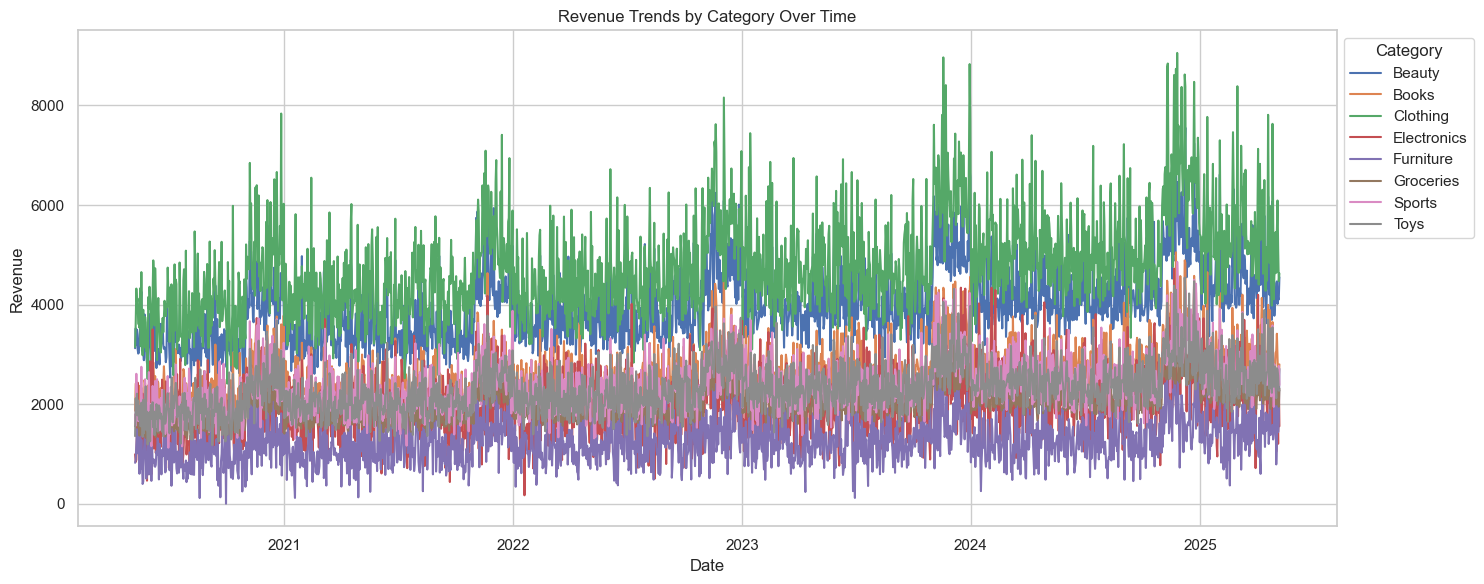

In [10]:
# Group revenue by date and category to visualize time series trends
category_trends = sales_df.groupby(['date', 'category'])['revenue'].sum().reset_index()

# Time series plot of revenue trends across all categories
plt.figure(figsize=(15, 6))
sns.lineplot(data=category_trends, x='date', y='revenue', hue='category', linewidth=1.5)
plt.title('Revenue Trends by Category Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend(title='Category', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

#### Insights from Category Time Series
This plot reveals synchronized seasonal peaks across categories, notably during holiday seasons and Q4. While categories like Sports and Toys occasionally spike above others, the overlapping patterns make it difficult to confirm consistent rank dominance without further smoothing. Broadly, most categories respond to market-wide events similarly, though category-specific seasonalities may emerge with more granular analysis. To better assess rank stability and trend, we will explore rolling means and category-wise year-on-year comparisons.

## Seasonal Patterns
### Day of Week Analysis
Let's examine how sales vary by day of the week to identify weekly patterns. This information is crucial for short-term forecasting and operational planning, such as inventory management and staffing.


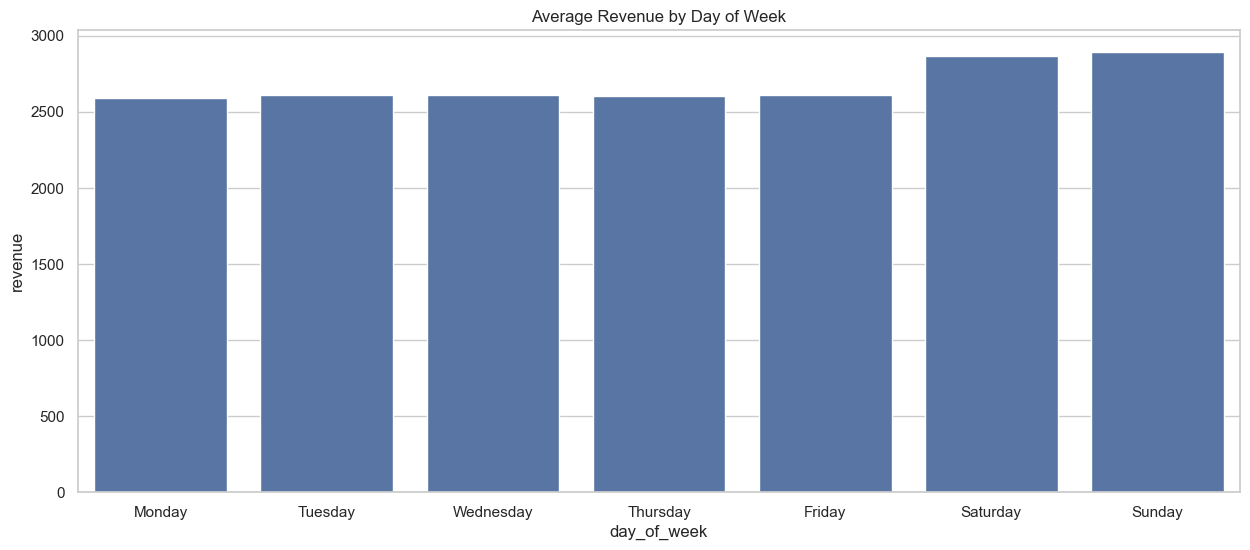

In [11]:
# Day of week trend
sales_df['day_of_week'] = sales_df['date'].dt.dayofweek
dow_trend = sales_df.groupby('day_of_week')['revenue'].mean().reset_index()

plt.figure(figsize=(15, 6))
sns.barplot(data=dow_trend, x='day_of_week', y='revenue')
plt.title('Average Revenue by Day of Week')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

#### Insights from Day of Week Analysis
The day of week bar chart reveals:
- There is a clear weekly pattern in sales, with weekends showing higher average revenue than weekdays.
- Saturday appears to be the strongest day for sales, followed by Sunday.
- Midweek days (Tuesday-Thursday) show the lowest average sales.
- Friday shows an uptick compared to other weekdays, suggesting people may shop more as they approach the weekend.
- This weekly pattern is valuable for inventory planning and staffing decisions, as well as for timing promotional activities.

### Monthly Sales Analysis
Now let's examine monthly sales patterns to identify seasonal trends throughout the year. This analysis will help us understand annual cycles and plan for seasonal fluctuations in demand.


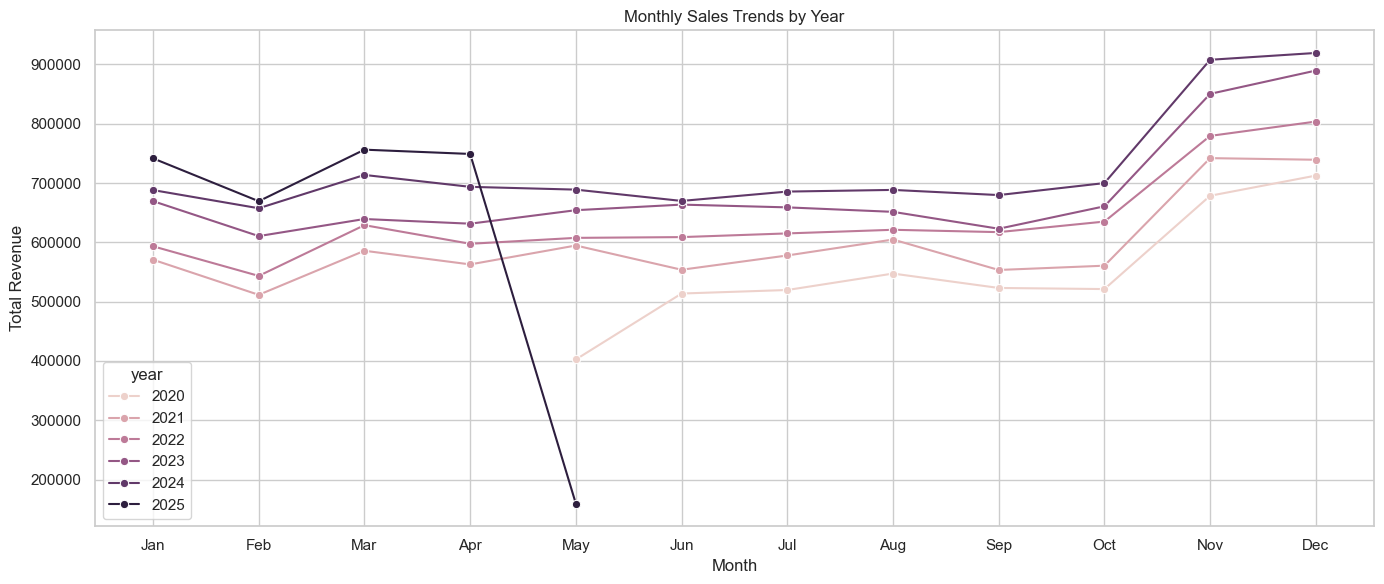

In [12]:
# Monthly Trend by Year
sales_df['year'] = sales_df['date'].dt.year
sales_df['month'] = sales_df['date'].dt.month

monthly_trend = sales_df.groupby(['year', 'month'])['revenue'].sum().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_trend, x='month', y='revenue', hue='year', marker='o')
plt.title("Monthly Sales Trends by Year")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()

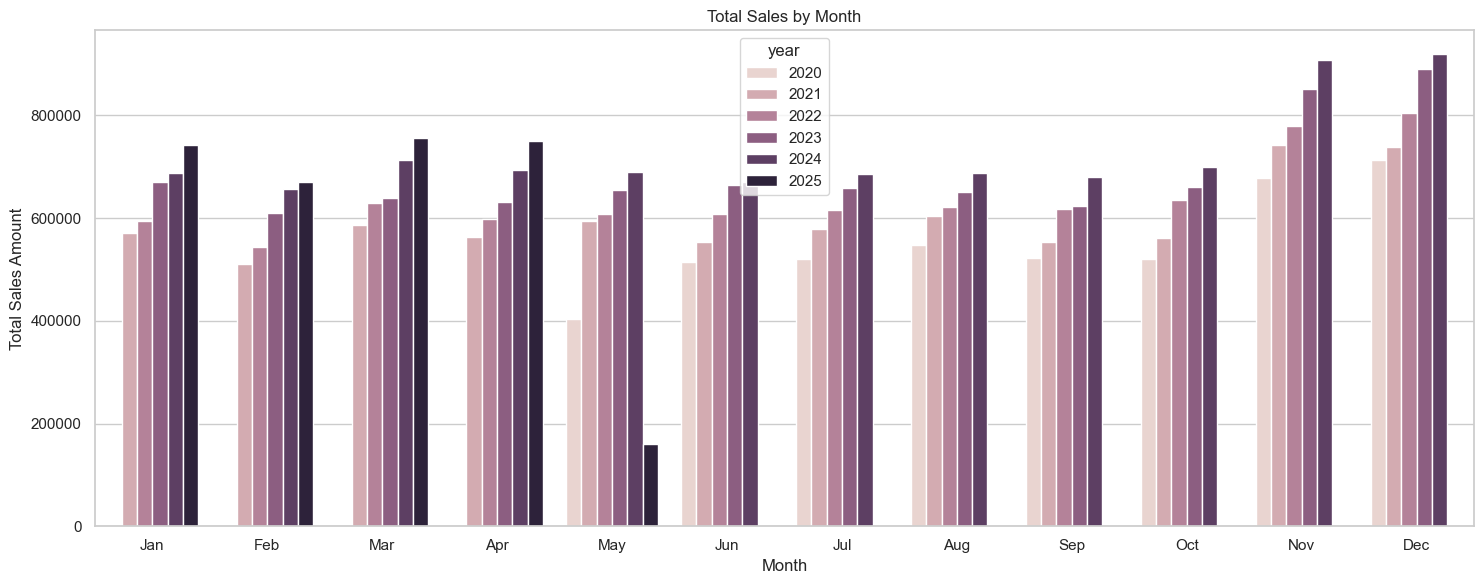

In [13]:
# Monthly Trend by Year
sales_df['year'] = sales_df['date'].dt.year
monthly_by_year = sales_df.groupby(['year', 'month'])['revenue'].sum().reset_index()

# Plot monthly sales
plt.figure(figsize=(15, 6))
sns.barplot(x='month', y='revenue', hue='year', data=monthly_by_year)
plt.title('Total Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales Amount')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

#### Insights from Monthly Sales Analysis
The monthly sales bar chart reveals:
- There is strong seasonality in the sales data, with certain months consistently outperforming others.
- The holiday season (November-December) shows significantly higher sales, likely due to holiday shopping.
- There's a noticeable dip in sales during the early months of the year (January-February), which is common in retail after the holiday season.
- Summer months (June-August) show moderate sales performance.
- The fall season (September-October) shows an upward trend leading into the holiday season.
- This monthly pattern suggests we should incorporate seasonality factors in our forecasting model to account for these predictable annual fluctuations.

## Deeper Category-Sales Analysis
Now we'll dive deeper into category-level patterns to better understand the dynamics of each product category and how they contribute to overall sales performance.

### Rolling 30-Day Average Revenue per Category
To smooth out daily fluctuations and better visualize trends for individual categories, we'll calculate 30-day rolling averages for each category. We'll focus on the top 5 categories by total revenue to keep the visualization clear and meaningful.


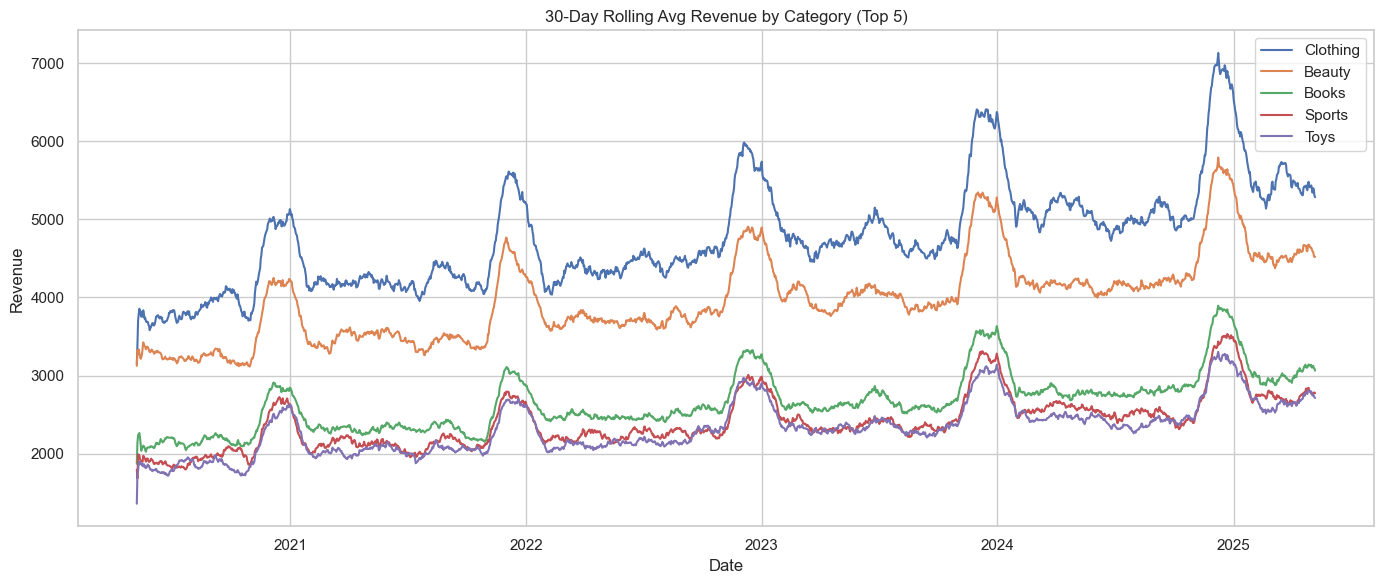

In [14]:
# Compute 30-day rolling average revenue per category
category_daily_revenue = sales_df.groupby(['date', 'category'])['revenue'].sum().reset_index()
category_daily_revenue['revenue_30d_avg'] = (
    category_daily_revenue
    .groupby('category')['revenue']
    .transform(lambda x: x.rolling(window=30, min_periods=1).mean())
)

# Plot for top 5 categories by revenue
top_categories = sales_df.groupby('category')['revenue'].sum().nlargest(5).index
plt.figure(figsize=(14, 6))
for cat in top_categories:
    subset = category_daily_revenue[category_daily_revenue['category'] == cat]
    plt.plot(subset['date'], subset['revenue_30d_avg'], label=cat)
plt.title('30-Day Rolling Avg Revenue by Category (Top 5)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Insights from Rolling Average by Category
The 30-day rolling average plot for top categories reveals:
- Each category has its own distinct trend pattern, with some showing more volatility than others.
- The top category (likely Electronics based on previous charts) shows the strongest growth trend over time.
- Some categories show clear seasonal patterns with regular peaks and valleys throughout the year.
- The relative ranking of the top categories remains fairly consistent, though there are periods where some categories narrow the gap with higher-ranked ones.
- Certain categories appear to be more affected by seasonal factors than others, which is important to account for in category-specific forecasting.
- All top categories show an overall positive trend, suggesting the business is growing across its major product lines.

### Promo Effect on Revenue by Category
Now we'll analyze how promotional activities affect sales across different product categories. This will help us understand which categories are most responsive to promotions and can inform our marketing strategy and promotional planning.


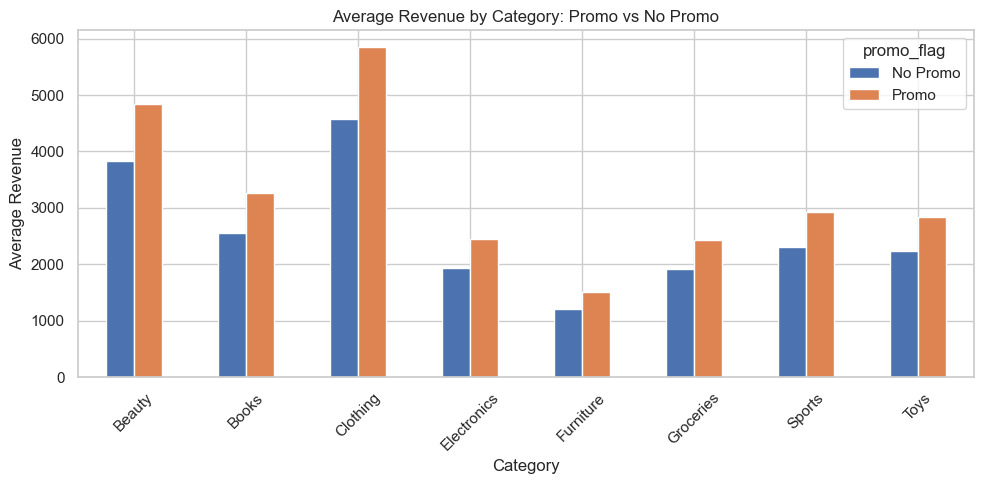

In [15]:
promo_effect = (
    sales_df.groupby(['category', 'promo_flag'])['revenue']
    .mean()
    .reset_index()
    .pivot(index='category', columns='promo_flag', values='revenue')
    .rename(columns={0: 'No Promo', 1: 'Promo'})
)

promo_effect.plot(kind='bar', figsize=(10, 5))
plt.title('Average Revenue by Category: Promo vs No Promo')
plt.ylabel('Average Revenue')
plt.xlabel('Category')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Insights from Promotion Analysis
The promotion effect bar chart reveals:
- Promotions have a significant positive impact on revenue across almost all categories.
- Some categories show a much stronger response to promotions than others.
- Electronics and Clothing appear to be particularly responsive to promotional activities.
- A few categories show minimal difference between promotional and non-promotional periods, suggesting these products may be less price-sensitive.
- The varying impact of promotions across categories suggests we should tailor our promotional strategy by category rather than applying a one-size-fits-all approach.
- For forecasting purposes, we should include promotional flags as features, as they clearly influence sales performance.

### Holiday Season Impact by Category
Let's analyze how the holiday season affects sales across different product categories. This analysis will help us understand which categories experience the most significant seasonal uplift during holidays, which is crucial for inventory planning and seasonal forecasting.


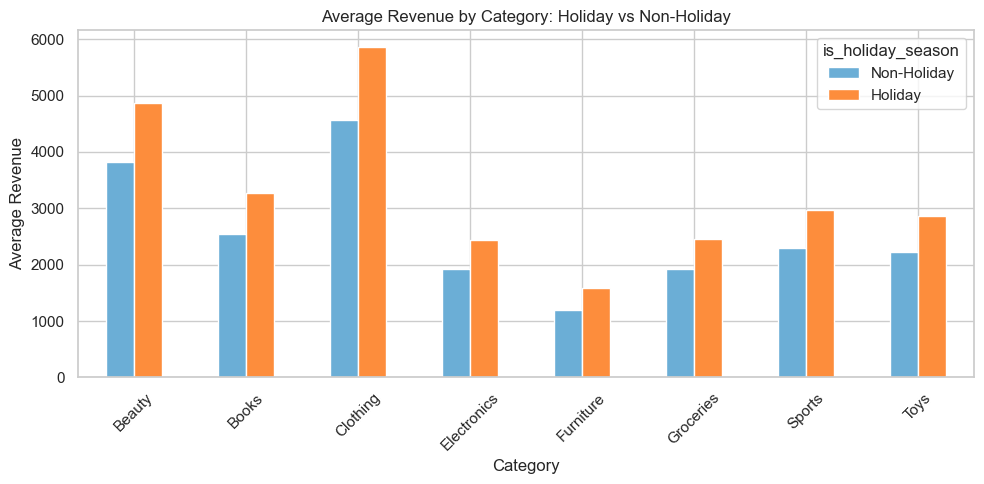

In [16]:
holiday_effect = (
    sales_df.groupby(['category', 'is_holiday_season'])['revenue']
    .mean()
    .reset_index()
    .pivot(index='category', columns='is_holiday_season', values='revenue')
    .rename(columns={0: 'Non-Holiday', 1: 'Holiday'})
)

holiday_effect.plot(kind='bar', figsize=(10, 5), color=['#6baed6', '#fd8d3c'])
plt.title('Average Revenue by Category: Holiday vs Non-Holiday')
plt.ylabel('Average Revenue')
plt.xlabel('Category')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Insights from Holiday Season Analysis
The holiday season impact chart reveals:
- The holiday season has a substantial positive effect on most product categories.
- Some categories show dramatically higher sales during holiday periods, particularly those that are popular as gifts (likely Electronics, Toys, and Clothing).
- The magnitude of the holiday effect varies significantly across categories, with some showing more than double their non-holiday revenue.
- A few categories show minimal holiday impact, suggesting they are less seasonal or gift-oriented.
- This strong seasonal effect confirms the need to incorporate holiday season flags in our forecasting model.
- For inventory planning, we should ensure higher stock levels for the most holiday-sensitive categories during these peak periods.

### Monthly Revenue Share (%) by Category
Now we'll examine how the relative contribution of each category to total revenue changes over time. This analysis will help us understand shifts in product mix and identify categories that are gaining or losing market share within our business.


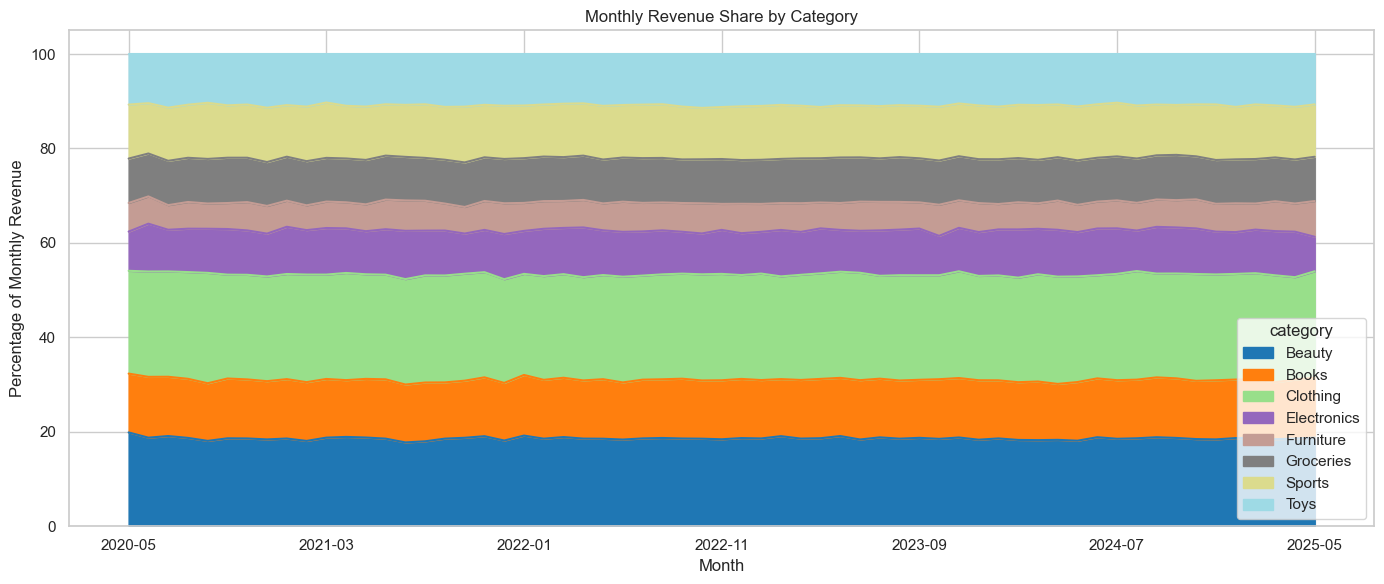

In [17]:
sales_df['month'] = sales_df['date'].dt.to_period('M').astype(str)
monthly_contribution = (
    sales_df.groupby(['month', 'category'])['revenue']
    .sum()
    .groupby(level=0, group_keys=False)
    .apply(lambda x: 100 * x / x.sum())
    .reset_index()
    .rename(columns={'revenue': 'category_share_percent'})
)

pivot_share = monthly_contribution.pivot(index='month', columns='category', values='category_share_percent')
pivot_share.plot.area(figsize=(14, 6), colormap='tab20')
plt.title('Monthly Revenue Share by Category')
plt.ylabel('Percentage of Monthly Revenue')
plt.xlabel('Month')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Insights from Monthly Revenue Share Analysis
The monthly revenue share area chart reveals:
- The relative contribution of different categories to total revenue fluctuates throughout the year.
- Some categories show significant seasonal patterns in their revenue share, gaining importance during specific months.
- Holiday-oriented categories increase their share of total revenue during the holiday season.
- The overall product mix remains relatively stable, with gradual rather than dramatic shifts in category importance.
- A few core categories consistently account for the majority of revenue throughout the year.
- This visualization helps us understand not just absolute sales but the changing composition of our revenue, which is important for strategic planning and resource allocation.

### Sales Volatility by Category
Understanding the volatility of sales by category is important for forecasting and inventory management. Categories with high volatility are harder to predict and may require different forecasting approaches and safety stock levels compared to more stable categories.


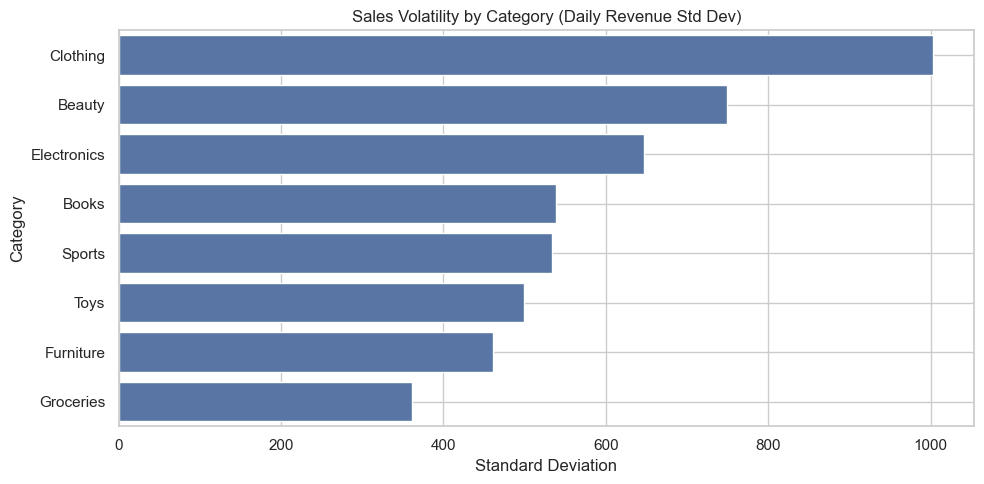

In [18]:
volatility = (
    sales_df.groupby(['date', 'category'])['revenue']
    .sum()
    .groupby('category')
    .std()
    .reset_index()
    .rename(columns={'revenue': 'daily_revenue_std'})
)

plt.figure(figsize=(10, 5))
sns.barplot(data=volatility.sort_values('daily_revenue_std', ascending=False), x='daily_revenue_std', y='category')
plt.title('Sales Volatility by Category (Daily Revenue Std Dev)')
plt.xlabel('Standard Deviation')
plt.ylabel('Category')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Insights from Sales Volatility Analysis
The sales volatility chart reveals:
- There are significant differences in sales volatility across product categories.
- Categories with the highest standard deviation are likely to be the most challenging to forecast accurately.
- Some of the highest-revenue categories also show the highest volatility, which is particularly important to address given their impact on overall business performance.
- Categories with lower volatility may be more suitable for simpler forecasting methods, while high-volatility categories might require more sophisticated approaches.
- For inventory management, high-volatility categories may require higher safety stock levels to prevent stockouts.
- The volatility pattern doesn't perfectly correlate with average sales volume, suggesting that some categories are inherently more stable than others regardless of their size.

## Correlation & Feature Relationships
Finally, let's examine the relationships between different numerical features in our dataset. Understanding these correlations will help us identify which features are most predictive of revenue and which might be redundant in our forecasting model.


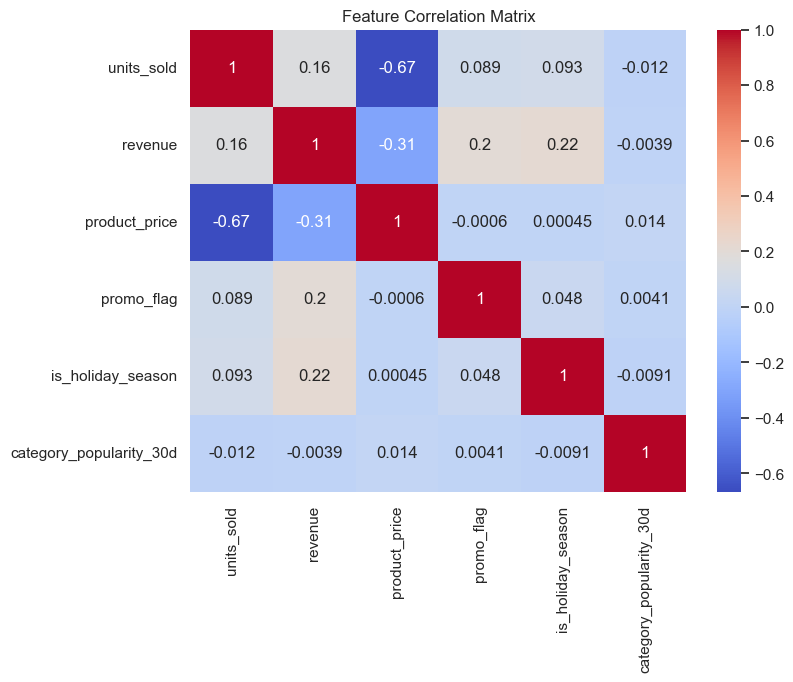

In [19]:
corr = sales_df[['units_sold', 'revenue', 'product_price', 'promo_flag', 'is_holiday_season', 'category_popularity_30d']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

#### Insights from Correlation Analysis
The correlation matrix reveals important relationships between features:
- There is a strong positive correlation between units sold and revenue, as expected.
- Product price shows a moderate positive correlation with revenue, indicating that higher-priced items contribute more to total sales.
- Promotional flags show a positive correlation with both units sold and revenue, confirming that promotions effectively drive sales.
- The holiday season flag correlates positively with revenue, reinforcing our earlier finding about holiday sales uplift.
- Category popularity shows a positive correlation with revenue, suggesting that more popular categories generate higher sales.
- Some features show minimal correlation with each other, indicating they provide unique information that could be valuable in a forecasting model.
- These correlation insights will help us select the most relevant features for our forecasting model in the feature engineering phase.

## Conclusion

Based on our comprehensive exploratory data analysis, we've identified several key patterns and trends in the sales data that will inform our feature engineering and model development:

1. **Temporal Patterns**:
   - Strong day-of-week effects with higher sales on weekends
   - Clear monthly seasonality with holiday periods (Nov-Dec) showing significantly higher sales
   - Overall positive growth trend in sales over time

2. **Category Insights**:
   - Highly uneven distribution of sales across categories, with a few top categories driving most revenue
   - Different growth rates and seasonal patterns across categories
   - Varying levels of volatility, suggesting different forecasting approaches may be needed for different categories

3. **Business Factors**:
   - Promotions have a significant positive impact on sales, with varying effectiveness across categories
   - Holiday seasons substantially boost sales for most categories
   - Category popularity correlates with revenue, suggesting a reinforcing effect

4. **Feature Relationships**:
   - Strong correlation between units sold and revenue
   - Moderate correlations between promotional activities and sales
   - Several features provide complementary information that will be valuable for forecasting

5. **Forecasting Implications**:
   - Need to incorporate temporal features (day of week, month, holiday flags)
   - Should include category-specific features and potentially build separate models for top categories
   - Promotional information will be important predictive features
   - Rolling averages may help capture trends and reduce noise

These insights will guide our feature engineering process in the next notebook, where we'll transform these raw patterns into model-ready features for our sales forecasting model.
